# Multi TARE experiments

In [1]:
import datetime
import os
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

SCENARIO = "indoor"

In [2]:
DATAFIELDS = ["scenario", "delay_time", "num_robots", "robot_id", "time", "volume_explored", "total_time", "total_volume_explored", "exploration_efficiency", "datetime"]
DELAY_TIME_LOG_PATTERN = r"delayInSeconds:\s+(\d+)"
NUM_ROBOTS_LOG_PATTERN = r"Number of robots:\s+(\d+)"
EXPLORED_VOLUME_LOG_PATTERN = r"\[Global\] (\d+\.\d+): (\d+\.\d+)"
EXPLORED_VOLUME_TARE_LOG_PATTERN = r"\[Robot 0\] (\d+\.\d+): (\d+\.\d+)"
EXPLORATION_COMPLETED_LOG_PATTERN = r"Exploration completed, returning home"
EXPLORATION_RESTARTED_LOG_PATTERN = r"Restarting exploration"


Datetime comparison utils funcs

In [3]:
def is_date_inside_cutoff(
    datetime_: datetime.datetime,
    cutoff_datetime_start: datetime.datetime,
    cutoff_datetime_end: datetime.datetime,
) -> bool:
    return cutoff_datetime_start < datetime_ < cutoff_datetime_end

def str_to_datetime(datetime_str: str) -> datetime.datetime:
    return datetime.datetime.strptime(datetime_str, "%Y_%m_%d_%H_%M_%S")

Logs loading utils func

In [4]:
def get_experiments_logs(
    base_logs_dir: str,
) -> list[str]:
    logs_dirs = os.listdir(base_logs_dir)
    # logs_dirs.remove(".gitkeep")
    filter_func_1 = lambda x: "experiment" in x
    news_logs_dirs = list(filter(filter_func_1, logs_dirs))
    return list(news_logs_dirs)
    # filter_func_2 = lambda x: is_date_inside_cutoff(str_to_datetime(x[len("experiment_"):]), cutoff_datetime_start, cutoff_datetime_end)
    # return list(filter(filter_func_2, news_logs_dirs))

def read_logs(
    experiment_logs_dir: str,
    logs_filename: str,
) -> list[str] | None:
    logs_filepath = os.path.join(experiment_logs_dir, logs_filename)
    if not os.path.exists(logs_filepath):
        return None
    with open(logs_filepath, 'r') as file:
        lines = file.readlines()
    return lines

Logs extraction

In [5]:
def get_delay_time_and_num_robots(planner_logs: list[str],) -> tuple[int, int]:
    delay_time = num_robots = None
    for log in planner_logs:
        delay_time_match = re.search(DELAY_TIME_LOG_PATTERN, log)
        if delay_time_match:
            delay_time = int(delay_time_match.group(1))
        num_robots_match = re.search(NUM_ROBOTS_LOG_PATTERN, log)
        if num_robots_match:
            num_robots = int(num_robots_match.group(1))
    if delay_time is None:
        raise RuntimeError(f"No delay time found: {planner_logs}")
    if num_robots is None:
        raise RuntimeError("No num robots found")
    return delay_time, num_robots

def get_time_and_explored_volume(robot_logs: list[str], tare: bool = False) -> tuple[list[tuple[float, float]], float, float]:
    times_and_explored_volumes = []
    time = explored_volume = 0
    time_at_exploration_completed = 0
    explored_volume_at_exploration_completed = 0
    exploration_stopped = False
    for log in robot_logs:
        if tare:
            match = re.search(EXPLORED_VOLUME_TARE_LOG_PATTERN, log)
        else:
            match = re.search(EXPLORED_VOLUME_LOG_PATTERN, log)
        if match:
            time = float(match.group(1))
            explored_volume = float(match.group(2))
            times_and_explored_volumes.append((time, explored_volume))
        if re.search(EXPLORATION_COMPLETED_LOG_PATTERN, log):
            exploration_stopped = True
            time_at_exploration_completed = time
            explored_volume_at_exploration_completed = explored_volume
        if re.search(EXPLORATION_RESTARTED_LOG_PATTERN, log):
            exploration_stopped = False
        if time >= 300:
            break
            
    if explored_volume_at_exploration_completed == 0 or not exploration_stopped:
        time_at_exploration_completed = time
        explored_volume_at_exploration_completed = explored_volume
    return times_and_explored_volumes, time_at_exploration_completed, explored_volume_at_exploration_completed

def calc_exploration_efficiency(times_and_explored_volumes: tuple[float, float]) -> tuple[float, float, float]:
    v_max = 0
    t_at_v_max = 0
    for t, v in times_and_explored_volumes:
        if v > v_max:
            v_max = v
            t_at_v_max = t
    if t_at_v_max == 0 or v_max == 0:
        return 0
    return v_max / t_at_v_max

# WINDOW_SIZE = 50

# def calc_exploration_efficiency(times_and_explored_volumes: list[tuple[float, float]]) -> list[tuple[float, float, float]]:
#     if len(times_and_explored_volumes) < WINDOW_SIZE:
#         return [(i[0], i[1], 0) for i in times_and_explored_volumes]
#         return (0, 0, 0)
#     data = [(times_and_explored_volumes[i][0], times_and_explored_volumes[i][1], 0) for i in range(WINDOW_SIZE)]
#     for i in range(len(times_and_explored_volumes) - WINDOW_SIZE):
#         d_vol = (times_and_explored_volumes[i + WINDOW_SIZE][1] - times_and_explored_volumes[i][1])
#         d_t = (times_and_explored_volumes[i + WINDOW_SIZE][0] - times_and_explored_volumes[i][0])
#         exploration_efficiency = d_vol / d_t
#         data.append((times_and_explored_volumes[i + WINDOW_SIZE][0], times_and_explored_volumes[i + WINDOW_SIZE][1], exploration_efficiency))
#     return data

def extract_global_exploration_data(
    base_logs_dir: str,
    experiment_logs_dir_name: str,
) -> pd.DataFrame:
    experiment_logs_dir = os.path.join(base_logs_dir, experiment_logs_dir_name)
    planner_logs = read_logs(experiment_logs_dir, "planner.log")
    if planner_logs:
        delay_time, num_robots_ = get_delay_time_and_num_robots(planner_logs)
        tare = False
    else:
        tare = True
        delay_time = 0
        num_robots_ = 1
    data = []
    total_times = []
    total_volumes =[]
    for robot_id in range(num_robots_):
        robot_logs = read_logs(experiment_logs_dir, f"robot_{robot_id}.log")
        times_and_explored_volumes, total_time, total_vol = get_time_and_explored_volume(robot_logs, tare)
        total_times.append(total_time)
        total_volumes.append(total_vol)
        data.append(times_and_explored_volumes)
    data_with_exploration_eff = []
    for robot_id, d in enumerate(data):
        exploration_efficiency = calc_exploration_efficiency(d)
        # print(d[-1],
        #     total_times[robot_id],
        #     total_volumes[robot_id],
        #     exploration_efficiency)
        data_with_exploration_eff.extend([(
            SCENARIO,
            delay_time,
            num_robots_,
            robot_id,
            i[0], i[1],
            total_times[robot_id],
            total_volumes[robot_id],
            exploration_efficiency,
            experiment_logs_dir_name
        ) for i in d])
    return pd.DataFrame(data_with_exploration_eff, columns=DATAFIELDS)

In [6]:
def load_logs_df(logs_dir: str):
    experiment_logs = get_experiments_logs(logs_dir)
    df = extract_global_exploration_data(logs_dir, experiment_logs[0])
    for logs in tqdm(experiment_logs, ncols=80):
        df = pd.concat([df, extract_global_exploration_data(logs_dir, logs)])
    df = df[df["total_time"]>200]
    df = df[df["total_volume_explored"]>2000]
    df = df[df["exploration_efficiency"]>10]
    df.describe()
    return df

In [7]:
# TARE_START = str_to_datetime("2024_05_29_13_50_00")
# TARE_END = str_to_datetime("2024_05_29_15_00_00")
tare_df = load_logs_df("../logs_TARE-indoor/")
tare_df_garage = load_logs_df("../logs_TARE/")

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 434.01it/s]


In [8]:

# LOCAL PLANNING SUBOPTIMAL
# MULTI_TARE_START = str_to_datetime("2024_05_30_01_30_00")
# MULTI_TARE_END = str_to_datetime("2024_05_30_17_30_00")
# TSP_WITH_COST_START = str_to_datetime("2024_05_30_20_20_00")
# TSP_WITH_COST_END = str_to_datetime("2024_05_31_11_15_00")
# VRP_START = str_to_datetime("2024_05_31_12_50_00")
# VRP_END = str_to_datetime("2024_06_1_12_50_00")

# multi_tare_df_old = load_logs_df("../logs_OUTDATED-local-planning/logs_Multi-TARE/")
# tsp_with_cost_df_old = load_logs_df("../logs_OUTDATED-local-planning/logs_TSP-with-rewards//")
# vrp_df_old = load_logs_df("../logs_OUTDATED-local-planning/logs_VRP//")

In [10]:
# LOCAL PLANNING REVERTED
# MULTI_TARE_START = str_to_datetime("2024_06_13_18_40_00")
# MULTI_TARE_END = str_to_datetime("2024_06_14_05_20_00")
# TSP_WITH_COST_START = str_to_datetime("2024_06_14_10_00_00")
# TSP_WITH_COST_END = str_to_datetime("2024_06_14_20_55_00")
# VRP_START = str_to_datetime("2024_06_14_16_55_00")
# VRP_END = str_to_datetime("2024_06_14_22_10_00")

multi_tare_df_indoor = load_logs_df("../logs_Mutli-TARE-indoor/")
tsp_with_cost_df_indoor = load_logs_df("../logs_TSP-with-rewards-indoor")
vrp_df_indoor = load_logs_df("../logs_VRP-indoor/")

multi_tare_df_garage = load_logs_df("../logs_Mutli-TARE/")
tsp_with_cost_df_garage = load_logs_df("../logs_TSP-with-rewards")
vrp_df_garage = load_logs_df("../logs_VRP/")

100%|████████████████████████████████████████| 140/140 [00:00<00:00, 199.50it/s]


In [24]:
def get_exploration_efficiency(df, delay_times: list[int]):
    exploration_efficiency_mean = []
    exploration_efficiency_std = []

    for i, delay_time in enumerate(delay_times):
        df_delay_time = df[df["delay_time"]==delay_time]
        df_delay_time = df_delay_time[df_delay_time["robot_id"]==0]
        if len(df_delay_time) == 0:
            continue
        exploration_efficiency_mean.append(df_delay_time["exploration_efficiency"].unique().mean())
        exploration_efficiency_std.append(df_delay_time["exploration_efficiency"].unique().std())
    exploration_efficiency_mean = np.array(exploration_efficiency_mean)
    exploration_efficiency_std = np.array(exploration_efficiency_std)

    return exploration_efficiency_mean, exploration_efficiency_std


def plot_baseline(df, linestyle: str = '--', label: str = 'TARE', color: str = 'k'):
    exploration_efficiency_mean = df["exploration_efficiency"].unique().mean()
    exploration_efficiency_std = df["exploration_efficiency"].unique().std()
    plt.hlines([exploration_efficiency_mean], -10, 50, linestyles=linestyle, color=color, label=label)


def plot_exploration_efficiency(df, num_robots: int, label: str, linestyle: str = '-', color: str | None = None, plot_error: bool = True):
    if num_robots == 1:
        plot_baseline(df, linestyle, label)
        return

    df_ = df[df["num_robots"] == num_robots]
    delay_times = df_["delay_time"].unique()
    delay_times.sort()
    exploration_efficiency_mean, exploration_efficiency_std = get_exploration_efficiency(df_, delay_times)

    delay_times_ = delay_times[:len(exploration_efficiency_mean)]
    line, = plt.plot(delay_times_, exploration_efficiency_mean, label=label, linestyle = linestyle, color=color)
    if plot_error:
        plt.fill_between(
            delay_times_,
            exploration_efficiency_mean-0.5*exploration_efficiency_std,
            exploration_efficiency_mean+0.5*exploration_efficiency_std,
            color=line.get_color(),
            alpha=0.2
        )

def plot_exploration_efficiency_boxplot(df, num_robots: int, delay_times: list[int], offset: int = 0, label: str | None = None, color: str | None = None, width: float = 3):
    if num_robots == 1:
        plot_baseline(df)
        return
    df_ = df[df["num_robots"] == num_robots]
    exploration_efficiency_mean, exploration_efficiency_std = get_exploration_efficiency(df_, delay_times)
    rect = plt.bar(
        np.array(delay_times) + offset*width,
        exploration_efficiency_mean,
        yerr=exploration_efficiency_std,
        width=width, label=label, color=color
    )

def plot_boxplot(x, y, y_err, offset: int = 0, label: str | None = None, color: str | None = None, width: float = 3):
    rect = plt.bar(
        np.array(x) + offset*width,
        y, yerr=y_err,
        width=width, label=label, color=color
    )

In [12]:
%matplotlib widget

def plot_exploration_over_time(df):
    num_robots = df["num_robots"].unique()
    delay_times = df["delay_time"].unique()
    num_robots.sort()
    delay_times.sort()
    fig, axes = plt.subplots(nrows=len(num_robots)+1, ncols=len(delay_times), figsize=(10, 5), sharey=True, sharex=True)
    axes[0][0].set_xlim([0,365])
    axes[0][0].set_ylim([0,6000])
    
    for date in df["datetime"].unique():
        exp_df = df[df["datetime"]==date]
        num_robots_ = exp_df["num_robots"].mode()[0]
        delay_time = exp_df["delay_time"].mode()[0]
        for robot_id in range(num_robots_):
            robot_df = exp_df[exp_df["robot_id"] == robot_id]
            axes[num_robots_//2-1][delay_time//5].plot(robot_df["time"].values, robot_df["volume_explored"].values)
    
    
    fig.supxlabel("Delay time")
    fig.supylabel("Number of robots")
    fig.suptitle("Explored Volume vs Time\nwith early stopping filter")
    
    plt.show()

In [13]:
plot_exploration_over_time(multi_tare_df)

NameError: name 'multi_tare_df' is not defined

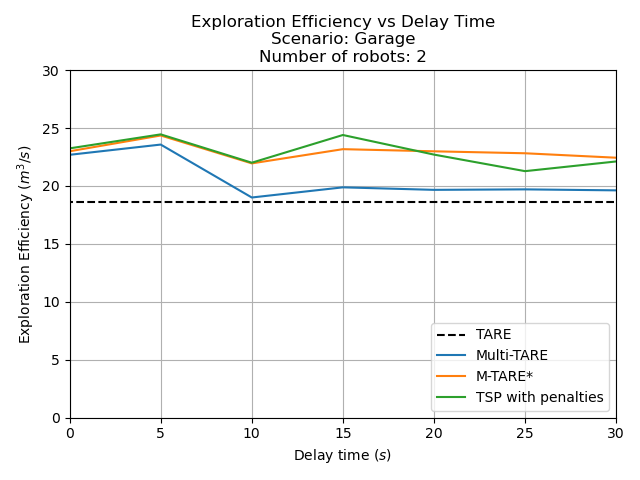

In [23]:
%matplotlib widget

# plot_exploration_efficiency(tare_df, 1, "TARE (indoor)", '--')
plot_exploration_efficiency(tare_df_garage, 1, "TARE", '--')

plot_exploration_efficiency(multi_tare_df_garage, 2, "Multi-TARE", '-', 'tab:blue', False)
plot_exploration_efficiency(vrp_df_garage, 2, "M-TARE*", '-', 'tab:orange', False)
plot_exploration_efficiency(tsp_with_cost_df_garage, 2, "TSP with penalties", '-', 'tab:green', False)

plt.xlabel("Delay time ($s$)")
plt.ylabel("Exploration Efficiency ($m^3/s$)")
plt.title("Exploration Efficiency vs Delay Time\nScenario: Garage\nNumber of robots: 2")
# plt.title("Exploration Efficiency vs Delay Time\nNumber of robots: 2")
plt.ylim([0,30])
plt.xlim([0,30])
plt.grid()
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()
# plt.savefig("garage_ylim.png")

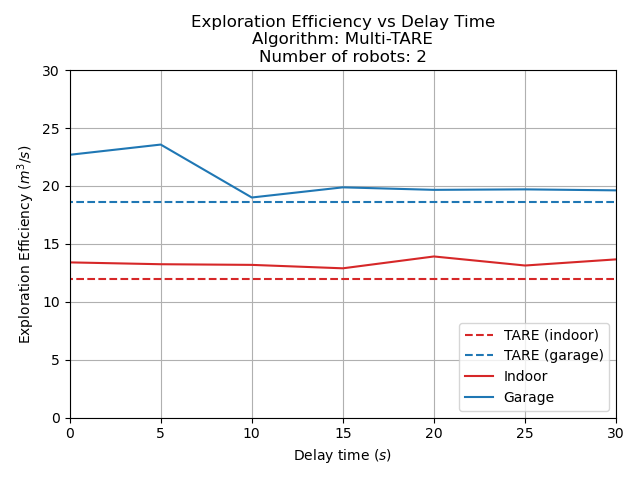

In [29]:
%matplotlib widget

plot_baseline(tare_df, linestyle = '--', label = 'TARE (indoor)', color = 'tab:red')
plot_baseline(tare_df_garage, linestyle = '--', label = 'TARE (garage)', color = 'tab:blue')

plot_exploration_efficiency(multi_tare_df_indoor, 2, "Indoor", '-', 'tab:red', False)
plot_exploration_efficiency(multi_tare_df_garage, 2, "Garage", '-', 'tab:blue', False)

plt.xlabel("Delay time ($s$)")
plt.ylabel("Exploration Efficiency ($m^3/s$)")
plt.title("Exploration Efficiency vs Delay Time\nAlgorithm: Multi-TARE\nNumber of robots: 2")
# plt.title("Exploration Efficiency vs Delay Time\nNumber of robots: 2")
plt.ylim([0,30])
plt.xlim([0,30])
plt.grid()
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()
# plt.savefig("garage_ylim.png")

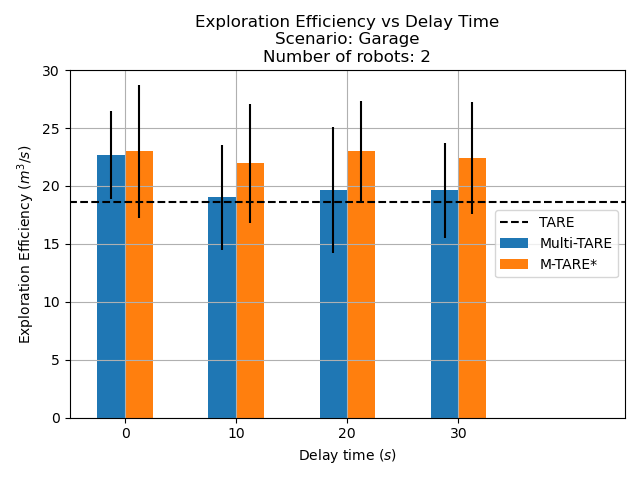

In [21]:
%matplotlib widget

plot_exploration_efficiency(tare_df_garage, 1, "TARE", '--')

x = [0, 10, 20, 30]

plot_exploration_efficiency_boxplot(multi_tare_df_garage, 2, x, -0.5, "Multi-TARE", 'tab:blue', 2.5)
plot_exploration_efficiency_boxplot(vrp_df_garage, 2, x, 0.5, "M-TARE*", 'tab:orange', 2.5)
# plot_exploration_efficiency_boxplot(tsp_with_cost_df_garage, 2, x, 0.5, "TSP with\npenalties", 'tab:green', 1.5)

plt.xlabel("Delay time ($s$)")
plt.ylabel("Exploration Efficiency ($m^3/s$)")
plt.title("Exploration Efficiency vs Delay Time\nScenario: Garage\nNumber of robots: 2")
plt.ylim([0,30])
plt.xlim([min(x)-5, max(x)+15])
plt.xticks(x)
plt.grid()
plt.legend(loc='right')

plt.tight_layout()

plt.show()

In [107]:
print(tare_df["exploration_efficiency"].unique().mean())
print(tare_df["exploration_efficiency"].unique().std())
print(tare_df_garage["exploration_efficiency"].unique().mean())
print(tare_df_garage["exploration_efficiency"].unique().std())

11.98917606099651
0.7303827785060365
18.60684740412506
3.1329827288205543


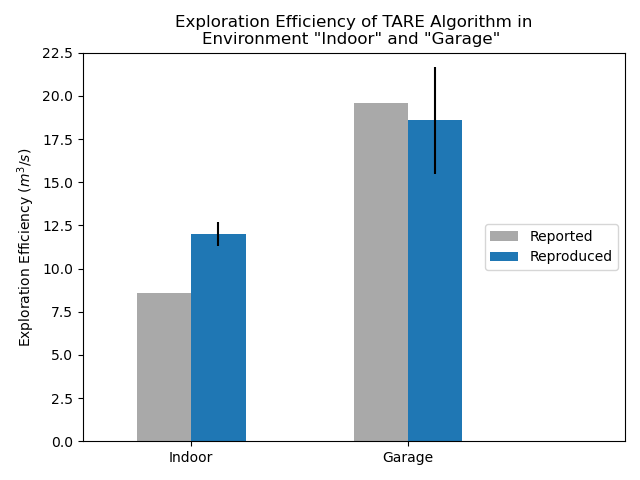

In [140]:
%matplotlib widget

x = [0, 10]


plot_boxplot(x, [8.6, 19.6], None, -0.5, "Reported", "darkgray", 2.5)
plot_boxplot(x, [12, 18.6], [0.7, 3.1], 0.5, "Reproduced", "tab:blue", 2.5)


plt.ylabel("Exploration Efficiency ($m^3/s$)")
plt.ylim([0,22.5])
plt.xlim([-5,20])
# plt.grid()
plt.legend(loc='right')
plt.xticks(x, ["Indoor", "Garage"])
plt.title("Exploration Efficiency of TARE Algorithm in\nEnvironment \"Indoor\" and \"Garage\" ")
plt.tight_layout()

plt.show()

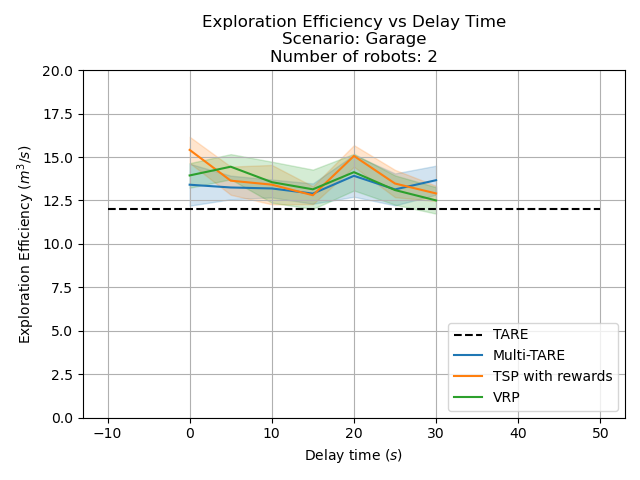

In [133]:
%matplotlib widget

plot_exploration_efficiency(tare_df, 1, "TARE", '--')

plot_exploration_efficiency(multi_tare_df, 2, "Multi-TARE", '-')
plot_exploration_efficiency(tsp_with_cost_df, 2, "TSP with rewards", '-')
plot_exploration_efficiency(vrp_df, 2, "VRP", '-')

# plot_exploration_efficiency(multi_tare_df_old, 2, "Multi-TARE", '-')
# plot_exploration_efficiency(tsp_with_cost_df_old, 2, "TSP with rewards", '-')
# plot_exploration_efficiency(vrp_df_old, 2, "VRP", '-')

plt.xlabel("Delay time ($s$)")
plt.ylabel("Exploration Efficiency ($m^3/s$)")
plt.title("Exploration Efficiency vs Delay Time\nScenario: Garage\nNumber of robots: 2")
plt.ylim([0,20])
plt.grid()
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()
# plt.savefig("garage_ylim.png")

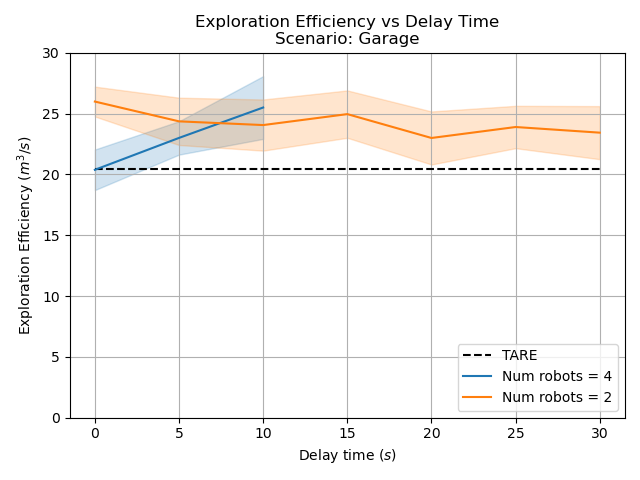

In [39]:
%matplotlib widget

plot_exploration_efficiency(tare_df, 1, "TARE", '--')
plot_exploration_efficiency(vrp_df, 4, "Num robots = 4", '-')
plot_exploration_efficiency(vrp_df, 2, "Num robots = 2", '-')
# plot_exploration_efficiency(tsp_with_cost_df, 4, "TSP with cost", '-')
# plot_exploration_efficiency(vrp_df, 4, "VRP", '-')
# plot_exploration_efficiency(multi_tare_2_df, 4, "MT2", '-')

plt.xlabel("Delay time ($s$)")
plt.ylabel("Exploration Efficiency ($m^3/s$)")
plt.title("Exploration Efficiency vs Delay Time\nScenario: Garage")
plt.ylim([0,30])
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
# plt.savefig("garage_ylim.png")

In [26]:
a = multi_tare_df[multi_tare_df["num_robots"]==6]
print(a["datetime"].unique())

['experiment_2024_06_15_20_34_02' 'experiment_2024_06_15_20_21_12'
 'experiment_2024_06_15_20_59_43' 'experiment_2024_06_15_20_40_27'
 'experiment_2024_06_15_20_46_53' 'experiment_2024_06_15_19_36_16'
 'experiment_2024_06_15_19_29_51' 'experiment_2024_06_15_19_55_32'
 'experiment_2024_06_15_19_04_10']


In [20]:
b = multi_tare_df[multi_tare_df["num_robots"] == 2]
b = b[b["delay_time"]==0]
len(b["exploration_efficiency"].unique())

16

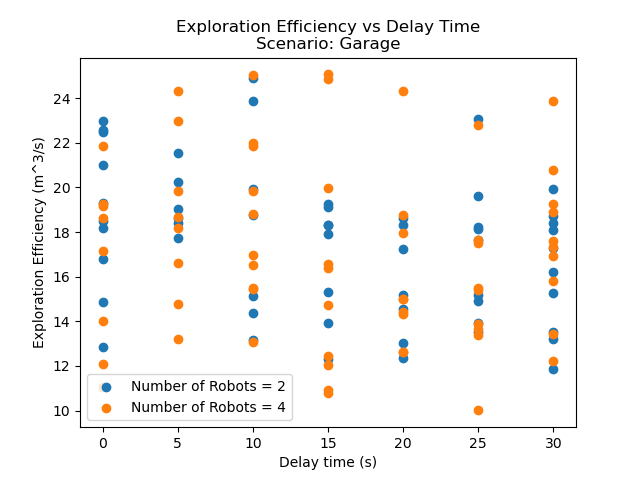

In [36]:
%matplotlib widget

for j in num_robots:
    delay_times_ = []
    exp_efficiency = []
    df_ = df[df["num_robots"] == j]
    for delay_time in delay_times:
        df_delay_time = df_[df_["delay_time"]==delay_time]
        exp_eff_at_delay_time = df_delay_time["exploration_efficiency"]
        for k in exp_eff_at_delay_time.unique():
            exp_efficiency.append(k)
            delay_times_.append(delay_time)
    
    plt.scatter(delay_times_, exp_efficiency, label=f"Number of Robots = {j}")

plt.xlabel("Delay time (s)")
plt.ylabel("Exploration Efficiency (m^3/s)")
plt.title("Exploration Efficiency vs Delay Time\nScenario: Garage")
plt.legend()
plt.show()

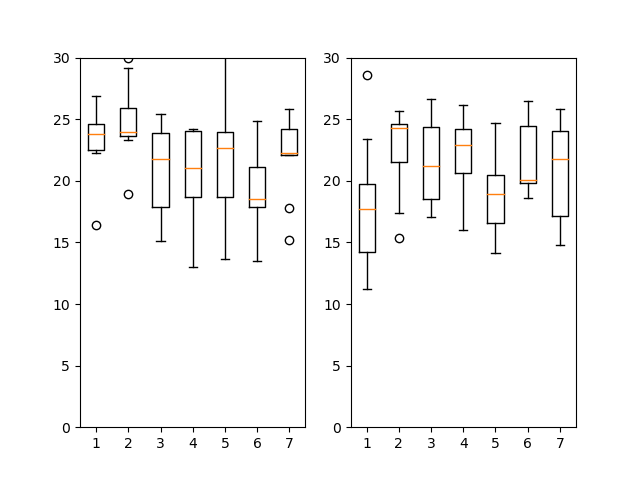